<a href="https://colab.research.google.com/github/BrandonJChan/301FinalProject/blob/master/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicting How Much I Like A Song**

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import files
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingRegressor, StackingRegressor

In [2]:
spotify_df = pd.read_csv('https://github.com/BrandonJChan/301FinalProject/blob/master/Data/final.csv?raw=true')
spotify_df.head()

,trackName,artistName,msPlayed,duration_ms,plays,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Say It (feat. Tove Lo),Flume,15502360,262521,59.051885,1,62,0.598,0.532,3,-6.833,0,0.0295,0.0668,0.000003,0.0617,0.2610,74.963,4
1,Freudian,Daniel Caesar,11709180,602297,19.440874,1,54,0.355,0.298,8,-12.277,1,0.0581,0.3100,0.002660,0.1850,0.0714,115.823,3
2,Feel Good (feat. Daya),Gryffin,10724803,248156,43.217988,0,72,0.625,0.707,2,-4.761,1,0.0337,0.2200,0.000000,0.2130,0.4790,138.064,4
3,Never Be Like You (feat. Kai),Flume,8174487,234910,34.798378,1,68,0.444,0.557,0,-5.476,1,0.0602,0.4530,0.000000,0.1520,0.2960,115.058,4
4,Get You (feat. Kali Uchis),Daniel Caesar,7469173,278180,26.850144,0,76,0.658,0.294,4,-8.533,0,0.0321,0.4220,0.000052,0.0749,0.3580,74.038,4


The potential predictors I will be looking at include:
*   Artist
*   Whether or not the song is explicit
*   Popularity
*   Danceability
*   Energy
*   Key
*   Loudness
*   Mode
*   Speechiness
*   Acosuticness
*   Instrumentallness
*   Liveness
*   Valence
*   Tempo

**Let's go!**

First let's get rid of some super extreme outliers.


In [3]:
spotify_df.loudness.sort_values().iloc[0:10]

4380   -60.000
1422   -60.000
4244   -60.000
3894   -53.341
3953   -35.710
4475   -35.475
2643   -34.475
822    -32.126
3354   -30.879
4226   -28.979
Name: loudness, dtype: float64

Those top 4 quietest "songs" are literally silent songs that I played one time.

In [0]:
spotify_df.drop([4380, 1422, 4244, 3894], inplace = True)


##**Transforming Variables**
The first thing I want to do is transform the variables so they are not as skewed. This is especially important with our response variable, plays. After lots of trial and error, I have found that the following power transformations resulted in the most normality among variables.

In [0]:
spotify_df['plays'] = spotify_df.plays**0.01
spotify_df['danceability'] = spotify_df.danceability**1.8
spotify_df['popularity'] = spotify_df.popularity**1.375
spotify_df['energy'] = spotify_df.energy**1.5
spotify_df['loudness'] = (spotify_df.loudness + 40)**4.5
spotify_df['speechiness'] = spotify_df.speechiness**0.365
spotify_df['acousticness'] = spotify_df.acousticness**0.3
spotify_df['instrumentalness'] = spotify_df.instrumentalness**0.0079
spotify_df['liveness'] = spotify_df.liveness**0.4

In [6]:
spotify_df

,trackName,artistName,msPlayed,duration_ms,plays,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Say It (feat. Tove Lo),Flume,15502360,262521,1.041627,1,291.432897,0.396335,0.388032,3,6.969119e+06,0,0.276366,0.444051,0.904924,0.328181,0.2610,74.963,4
1,Freudian,Daniel Caesar,11709180,602297,1.030118,1,241.013528,0.155028,0.162676,8,3.110148e+06,1,0.353936,0.703734,0.954238,0.509177,0.0714,115.823,3
2,Feel Good (feat. Daya),Gryffin,10724803,248156,1.038381,0,357.958090,0.429125,0.594469,2,9.153898e+06,1,0.290125,0.634931,0.000000,0.538706,0.4790,138.064,4
3,Never Be Like You (feat. Kai),Flume,8174487,234910,1.036133,1,330.902276,0.231894,0.415703,0,8.347280e+06,1,0.358552,0.788550,0.000000,0.470693,0.2960,115.058,4
4,Get You (feat. Kali Uchis),Daniel Caesar,7469173,278180,1.033450,0,385.583720,0.470768,0.159412,4,5.499827e+06,0,0.285019,0.771958,0.925031,0.354644,0.3580,74.038,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740,Prescription/Oxymoron,ScHoolboy Q,1032,429667,0.941468,1,181.864289,0.320015,0.868085,11,8.433578e+06,0,0.737987,0.405865,0.963230,0.405953,0.3760,119.997,4
4741,Dancing With Our Hands Tied,Taylor Swift,1031,211507,0.948155,0,297.915607,0.427890,0.574403,0,7.109196e+06,0,0.551663,0.430835,0.913749,0.452847,0.2840,160.024,4
4742,Voices,Saosin,1021,217525,0.947797,0,234.898001,0.119357,0.889637,9,1.018140e+07,0,0.419578,0.061916,0.963679,0.676919,0.2610,179.962,4
4743,Come Here,Sabrina Claudio,1020,242011,0.946777,0,210.872336,0.342037,0.371737,11,5.443424e+06,0,0.334816,0.944265,0.961101,0.686864,0.1990,140.020,4


In [0]:
X_train = spotify_df.drop(['trackName',
                           'msPlayed',
                           'duration_ms',
                           'plays',
                           'mode',
                           'time_signature'],
                          axis = 1)
y_train = spotify_df['plays']

##**K Nearest Neighbors**

To select the features, I will start with the most important feature, artist. I will then add features to the model, one by one, in order from highest correlation with plays to lowest correlation with plays up to whether or not a song is explicit. In other words, I will not consider features with a correlation less than the "explicit" variable's correlation. 

With each set of features, I will best model varying the number of neighbors from 1 to 25.

I will find the cross-validated MSE of each of the best models from the set of features and my final K Nearest Neighbors model will be the one with the lowest MSE.

In [0]:
ct1 = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['artistName']),
    remainder = 'drop'
)

pipeline = make_pipeline(
      ct1,
      KNeighborsRegressor(n_neighbors=50)
)

clf = GridSearchCV(pipeline,
                   param_grid={
                       "kneighborsregressor__n_neighbors": range(1, 25)
                       },
                   scoring="neg_mean_squared_error",
                   cv=10)
clf.fit(X_train[['artistName']], y_train)
clf.best_estimator_

In [0]:
feature_options = [
                   ['popularity'],
                   ['popularity', 'energy'],
                   ['popularity', 'energy', 'valence'],
                   ['popularity', 'energy', 'valence', 'instrumentalness'],
                   ['popularity', 'energy', 'valence', 'instrumentalness', 'acousticness'],
                   ['popularity', 'energy', 'valence', 'instrumentalness', 'acousticness', 'explicit']
                   ]

for i in range(len(feature_options)):
  ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['artistName']),
    (StandardScaler(), feature_options[i]),
    remainder = 'drop'
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=5)
  )

  clf = GridSearchCV(pipeline,
                   param_grid={
                       "kneighborsregressor__n_neighbors": range(1, 25)
                       },
                   scoring="neg_mean_squared_error",
                   cv=10)
  clf.fit(X_train[['artistName'] + feature_options[i]], y_train)

Based on the code above, the best models were:
*   Artist - 6 neighbors
*   \+ Popularity - 8 neighbors
*   \+ Energy - 8 neighbors
*   \+ Valence - 10 neighbors
*   \+ Instrumentalness - 16 neighbors
*   \+ Acousticness - 23 neighbors
*   \+ Explicit - 24 neighbors

Now I will find the cross-validated MSEs of each of these models and find the best model.

In [0]:
cv_scores_dict = {
    'Model': [],
    'MSE': []
}

In [0]:
ct1 = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['artistName']),
    remainder = 'drop'
)

pipeline = make_pipeline(
      ct1,
      KNeighborsRegressor(n_neighbors=6)
)

cv_scores_dict['Model'].append('Artist')
cv_scores_dict['MSE'].append(-cross_val_score(pipeline, X=X_train[['artistName']], y=y_train,
                             scoring="neg_mean_squared_error", cv=10).mean())

In [0]:
neighbors = [8, 8, 10, 16, 23, 24]

for i in range(len(neighbors)):
  ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['artistName']),
    (StandardScaler(), feature_options[i]),
    remainder = 'drop'
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=neighbors[i])
  )

  cv_scores_dict['Model'].append('+' + feature_options[i][-1].capitalize())
  cv_scores_dict['MSE'].append(-cross_val_score(pipeline, X=X_train[['artistName'] + feature_options[i]], y=y_train,
                             scoring="neg_mean_squared_error", cv=10).mean())

In [14]:
cv_scores_df = pd.DataFrame(cv_scores_dict)
cv_scores_df

,Model,MSE
0,Artist,0.000449
1,+Popularity,0.000433
2,+Energy,0.000448
3,+Valence,0.000468
4,+Instrumentalness,0.000481
5,+Acousticness,0.000492
6,+Explicit,0.000491


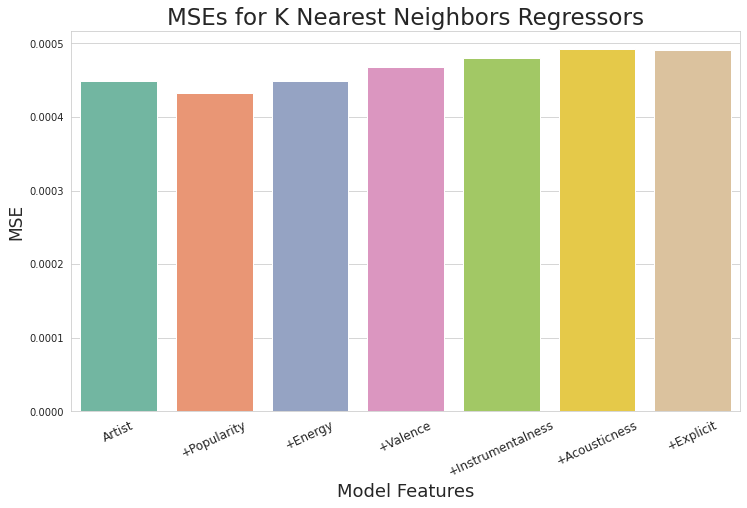

In [16]:
sns.set_style('whitegrid')
dims = (12,7)
fig, ax = plt.subplots(figsize = dims)
ax = sns.barplot(x = 'Model',
                 y = 'MSE',
                 data = cv_scores_df,
                 palette = 'Set2')

ax.set_xlabel('Model Features', fontsize = 18)
ax.set_ylabel('MSE', fontsize = 17)
ax.set_title('MSEs for K Nearest Neighbors Regressors', fontsize = 23)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, fontsize=12)

As shown by the graph, the K Nearest Neighbors Regressor with the lowest MSE is the model with just artist and popularity as features and 8 neighbors.

###**Best K Neighbors Model:**
### Features - Artist and Popularity
### Number of Neighbors - 8
### MSE = 0.000433

We will move forward assuming Artist and Popularity are the only worthwhile features based on the above analysis and because the other features are so poorly correlated with plays.

##**Ridge Regression**

Now, we're going to try a different regression model, Ridge Regression. I want to try Ridge Regression because it addresses the problem multicollinearity or correlation between features. In this case, there is defintely correlation between the artist and how popular their songs are. I want to try Ridge Regression both to address that problem and just to try something new.

I will be tuning the alpha hyperparameter to try to find the best Ridge Regression model.

In [17]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['artistName']),
    (StandardScaler(), ['popularity']),
    remainder = 'drop'
  )

cv_scores_dict = {
    'Model': [],
    'MSE': []
}

for alpha in [0, 0.5, 1, 5, 10, 20, 30, 40, 50, 100]:
  pipeline = make_pipeline(
      ct,
      Ridge(alpha=alpha)
  )
  cv_scores_dict['Model'].append(str(alpha))
  cv_scores_dict['MSE'].append(-cross_val_score(pipeline, X=X_train[['artistName', 'popularity']], y=y_train,
                             scoring="neg_mean_squared_error", cv=10).mean())


cv_scores_df = pd.DataFrame(cv_scores_dict)
cv_scores_df

,Model,MSE
0,0,0.000415
1,0.5,0.000403
2,1,0.000399
3,5,0.000406
4,10,0.000419
5,20,0.000435
6,30,0.000446
7,40,0.000454
8,50,0.000459
9,100,0.000474


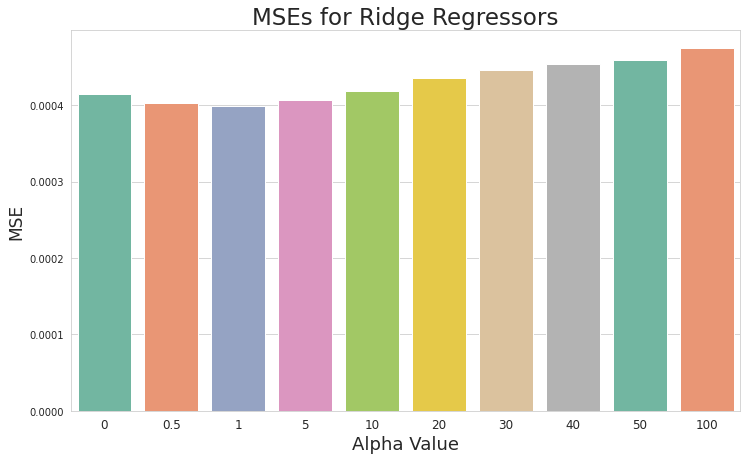

In [18]:
dims = (12,7)
fig, ax = plt.subplots(figsize = dims)
ax = sns.barplot(x = 'Model',
                 y = 'MSE',
                 data = cv_scores_df,
                 palette = 'Set2',
                 order = cv_scores_df['Model'].tolist())

ax.set_xlabel('Alpha Value', fontsize = 18)
ax.set_ylabel('MSE', fontsize = 17)
ax.set_title('MSEs for Ridge Regressors', fontsize = 23)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

As shown by the graph, the Ridge Regressor with the lowest MSE is the model with an alpha value of 1.

###**Best Ridge Regression Model:**
### Features - Artist and Popularity
### Alpha - 1
### MSE = 0.000399

##**Voting Regressor and Stacking Regressor**
I love these guys.

Let's see if combining our best K Nearest Neighbors Model with our best Ridge Regression Model end up being better than both of them individually. 

We'll start with the Voting Regressor.

In [0]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['artistName']),
    (StandardScaler(), ['popularity']),
    remainder = 'drop'
)

knn = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=8)
)

ridge = make_pipeline(
      ct,
      Ridge()
)

In [20]:
voting = VotingRegressor([
                          ('knn', knn),
                          ('ridge', ridge)
])

-cross_val_score(voting, X=X_train[['artistName', 'popularity']], y=y_train,
                             scoring="neg_mean_squared_error", cv=10).mean()

0.0004008026375473062

In [21]:
stacking = StackingRegressor([
    ("knn", knn), 
    ("ridge", ridge)],
    final_estimator=LinearRegression()
)

-cross_val_score(stacking, X=X_train[['artistName', 'popularity']], y=y_train,
                             scoring="neg_mean_squared_error", cv=10).mean()

0.0006004574083451241

###**Voting Regressor:**
###MSE = 0.000401

###**Stacking Regressor:**
###MSE = 0.000600

##**THE FINAL MODEL RANKING**

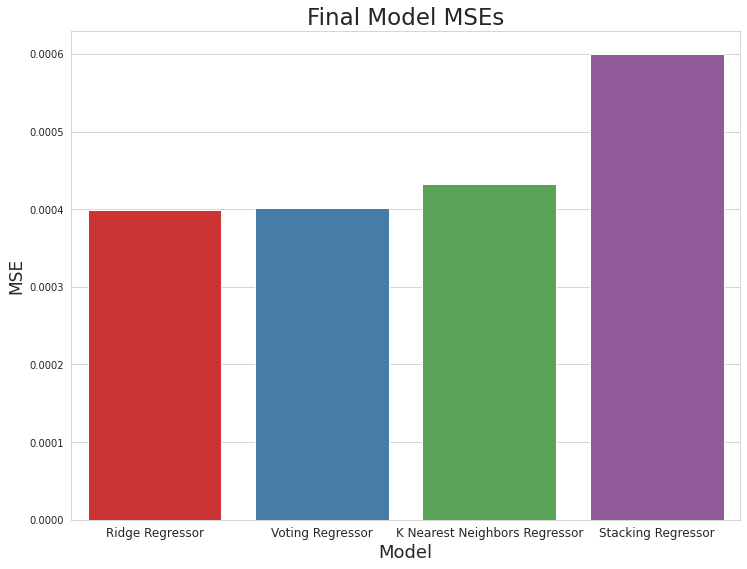

In [22]:
model_performance_df = pd.DataFrame({
    'Model': ['Ridge Regressor',
              'Voting Regressor',
              'K Nearest Neighbors Regressor',
              'Stacking Regressor'],
    'MSE': [0.000399, 0.000401, 0.000433, 0.000600]
})

dims = (12,9)
fig, ax = plt.subplots(figsize = dims)
ax = sns.barplot(x = 'Model',
                 y = 'MSE',
                 data = model_performance_df,
                 palette = 'Set1',
                 order = model_performance_df['Model'].tolist())

ax.set_xlabel('Model', fontsize = 18)
ax.set_ylabel('MSE', fontsize = 17)
ax.set_title('Final Model MSEs', fontsize = 23)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

###**Winner: Ridge Regressor!**

##**FINAL PREDICTIONS**

Now I will be using the Ridge Regressor to predict how much I will like the songs in my "Release Radar" playlist. The "Release Radar" playlist is a personalized playlist that contains recently released songs that spotify thinks I'll enjoy.

In [0]:
test_df = pd.read_csv('https://github.com/BrandonJChan/301FinalProject/blob/master/Data/final_test.csv?raw=true')
test_df

In [0]:
ridge.fit(X_train[['artistName', 'popularity']], y_train)
predictions = ridge.predict(test_df[['artistName', 'popularity']])
predictions_df = test_df[['trackName', 'artistName']]
predictions_df['predicted plays'] = pd.Series(predictions)**(1/0.01)
predictions_df

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


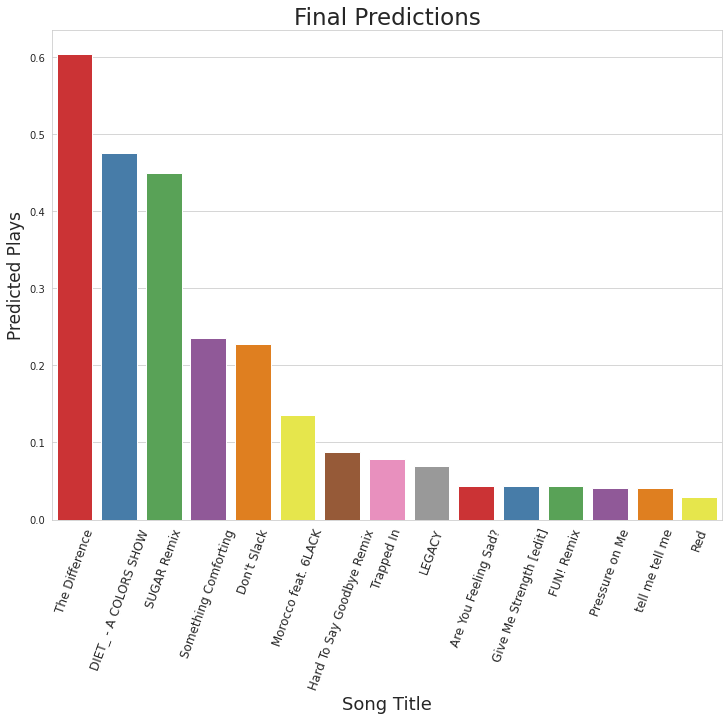

In [25]:
#Shortening song titles so it fits on the plot
predictions_df['trackName'].replace({
    'SUGAR (Remix) [feat. Dua Lipa]': 'SUGAR Remix',
    "Don't Slack (from Trolls World Tour)": "Don't Slack",
    'Hard To Say Goodbye (feat. Chloe Angelides) - Tep No Remix': 'Hard To Say Goodbye Remix',
    'FUN! - SILO x Martin Wave Remix': 'FUN! Remix'
},
inplace = True)

dims = (12,9)
fig, ax = plt.subplots(figsize = dims)
ax = sns.barplot(x = 'trackName',
                 y = 'predicted plays',
                 data = predictions_df,
                 palette = 'Set1',
                 order = predictions_df.sort_values('predicted plays', ascending = False)['trackName'].tolist())

ax.set_xlabel('Song Title', fontsize = 18)
ax.set_ylabel('Predicted Plays', fontsize = 17)
ax.set_title('Final Predictions', fontsize = 23)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, fontsize=12)

##**Conclusion**
I can validate these predictions from experience. I went through the playlist on my own before making the predictions and I know which songs I have played alot and which songs I haven't.

By far, I've played the SUGAR Remix more than any of the other songs, but I've also played The Difference, DIET_, and Trapped In alot. I haven't been playing Something Comforting, Don't Slack, and Morocco as much.

The predictions are not extremely accurate, but they get the general trends.

Looking back, the audio features that I extracted were not great. They don't represent the reason I choose to listen to or choose not to listen to a song.

Going forward, I would love to keep working on these predictions, trying more models and trying more features (lyrics, genres, featured artists, etc.).

In conclusion, I had fun and I learned a lot!